<a href="https://colab.research.google.com/github/AdPostma/open_collaboration_on_audio_classification/blob/master/Coo_Fastai2_Audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Maraques Coo calls model with Fastai2_audio 

Adapted from Fastai2_audio: 02_tutorial. Thanks to rbracco

In [ ]:
!pip install git+https://github.com/fastai/fastai2
!pip install git+https://github.com/fastai/fastcore
!pip install packaging
!pip install git+https://github.com/rbracco/fastai2_audio.git

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai2.torch_basics import *
from fastai2.basics import *
from fastai2.data.all import *
from fastai2.callback.all import *
from fastai2.vision.all import *

from fastai2_audio.core import *
from fastai2_audio.augment import *

import torchaudio

### Loading maraques coo soundfiles 24.4 kHz version

In [ ]:
Coo = untar_data('https://archive.org/download/macaques_24414hz_202007/macaques_24414Hz.zip')

In [ ]:
x = AudioGetter("", recurse=True, folders=None)
Coo_files  = x(Coo)

### Creating configuration file and item transformations

In [ ]:
#crop 750ms from the signal and turn it to a MelSpectrogram with no augmentation
cfg_voice = AudioConfig.Voice(sample_rate=24414,n_fft=1024, hop_length=140,f_max=12207)
a2s = AudioToSpec.from_cfg(cfg_voice)
crop_750ms = CropSignal(750)
tfms = [crop_750ms, a2s]

### Show example of Mellspectrogram
(show_batch() is broken in Fastai-2 Audio)


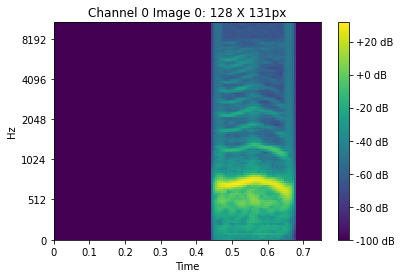

In [ ]:
pipe = Pipeline([AudioTensor.create, crop_750ms,a2s])
pipe(Coo_files[1]).show()

### Create audio dataloaders

In [ ]:
auds = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(seed=42),
                 item_tfms = tfms,
                 get_y=lambda x: str(x).split('/')[-1][:2])

In [ ]:
dbunch = auds.dataloaders(Coo, bs=64)

In [ ]:
dbunch.one_batch()[0].shape

torch.Size([64, 1, 128, 131])

### Create and train learner

In [ ]:
# credit to Kevin Bird and Hiromi Suenaga for these two lines to adjust a CNN model to take 1 channel input
def alter_learner(learn, channels=1):
    learn.model[0][0].in_channels=channels
    learn.model[0][0].weight = torch.nn.parameter.Parameter(learn.model[0][0].weight[:,1,:,:].unsqueeze(1))

In [ ]:
learn = Learner(dbunch, 
                xresnet18(),
                torch.nn.CrossEntropyLoss(), 
                metrics=[error_rate])
nchannels = dbunch.one_batch()[0].shape[1]
alter_learner(learn, nchannels)

In [ ]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.537560,0.407273,0.133150,00:22


epoch,train_loss,valid_loss,error_rate,time
0,0.120560,0.192001,0.061084,00:22
1,0.079518,0.270885,0.096774,00:22
2,0.034710,0.018015,0.005491,00:22
3,0.016162,0.012601,0.004118,00:22
4,0.007578,0.010043,0.002745,00:22
